# Data Science Workflow Project by Robert Wienröder

## Screencast here: https://cloud.bht-berlin.de/index.php/s/CSPpqwDTJLYrAcf

# Analysis of Political Coverage, Sentiment and Bias in New York Times Headlines

## Methodology

This project tried to analyze the political coverage in New York Times headlines over a 70-day period, with a focus on the U.S. presidential campaigns. The methodology consisted of the following steps:

1. **Data Collection**: Headlines from the New York Times website were scraped for a sample of the past 70 days.

2. **Categorization**: A machine learning model from Hugging Face, pre-trained on news headline classification tasks, was used to categorize the collected headlines.

3. **Candidate-Specific Analysis**: The dataset was filtered twice to isolate political headlines containing the keywords "Trump" or "Harris", the presidency candidates of the two major U.S. political parties.

4. **Coverage and Sentiment Analysis**: 
   a. Coverage analysis was performed to compare the frequency of headlines mentioning each candidate.
   b. Sentiment analysis was performed on the candidate-specific headlines.

5. **Bias Analysis**: A separate machine learning model, also from Hugging Face, was employed to conduct a bias analysis on the entire subset of headlines classified as political, to detect any overall ideological tendencies in the New York Times' politics section.


## Significance

This research provides insights into media representation of political figures and potential media bias in one of the United States' most prominent news sources during a critical period of the presidential campaign.

## Limitations

It's important to note that this analysis is based solely on headlines, which may not fully represent the nuanced content of full articles. Additionally, the accuracy of the results is dependent on the performance of the machine learning models used for categorization and bias detection.

## Part 1: Data Acquisition - Scraping New York Times Headlines

In [51]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import csv

def scrape_nyt_articles(days=70):
    all_article_data = []
    
    for day in range(days):
        # Calculate the date string for each day
        date_string = (datetime.now() - timedelta(days=day+1)).strftime("%Y/%m/%d")
        url = f"https://www.nytimes.com/sitemap/{date_string}/"
        
        # Send a get request with a user agent to avoid being blocked
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract article data and add to the list
        all_article_data.extend([
            {'title': a.text.strip(), 
             'link': f"https://www.nytimes.com{a['href']}" if not a['href'].startswith('http') else a['href'], 
             'date': date_string}
            for a in soup.find_all('a') if a.text.strip() and a.get('href')
        ])
    
    # Write the collected data to a CSV file
    if all_article_data:
        with open('nyt_articles.csv', 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=['title', 'link', 'date'])
            writer.writeheader()
            writer.writerows(all_article_data)
        
        print(f"Scraping complete. {len(all_article_data)} articles saved to 'nyt_articles.csv'.")
    else:
        print("No articles found.")

if __name__ == "__main__":
    scrape_nyt_articles()

Scraping complete. 26963 articles saved to 'nyt_articles.csv'.


## Part 2: Headline Categorization and Model Refinement

To start the web app, type in "python app.py" and then "http://127.0.0.1:5000" into the search bar of the browser.

In [59]:
import csv
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from collections import Counter

# Define categories and mapping
categories = [
    'Politics', 'U.S.', 'World', 'Sports', 'Science & Tech', 'Business & Economy',
    'Arts & Entertainment', 'Lifestyle'
]
category_mapping = {
    0: 6, 1: 6, 2: 0, 3: 5, 4: 1, 5: 6, 6: 1, 7: 6, 8: 7, 9: 0, 10: 6, 11: 0,
    12: 7, 13: 7, 14: 7, 15: 7, 16: 7, 17: 7, 18: 7, 19: 0, 20: 0, 21: 5, 22: 7,
    23: 7, 24: 0, 25: 0, 26: 0, 27: 4, 28: 3, 29: 7, 30: 7, 31: 7, 32: 4, 33: 2,
    34: 7, 35: 1, 36: 7, 37: 7, 38: 7, 39: 0, 40: 2, 41: 2
}

def categorize_articles(articles, model, tokenizer):
    for article in articles:
        
        # Tokenize the article title and get model prediction
        inputs = tokenizer(article['title'], truncation=True, padding=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            predicted_class = torch.argmax(model(**inputs).logits).item()
        
        # Map the predicted class to our category system
        article['predicted_category'] = categories[category_mapping.get(predicted_class, 7)]
    return articles

def main():
    # Load pre-trained model and tokenizer
    model_name = "dima806/news-category-classifier-distilbert"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # Read articles from CSV
    with open('nyt_articles.csv', 'r', newline='', encoding='utf-8') as infile:
        articles = list(csv.DictReader(infile))

    # Categorize articles
    categorized_articles = categorize_articles(articles, model, tokenizer)

    # Calculate and print category distribution
    category_distribution = Counter(article['predicted_category'] for article in categorized_articles)
    total_articles = len(categorized_articles)
    print("\nCategory Distribution:")
    for cat, count in category_distribution.items():
        percentage = int((count / total_headlines) * 100)
        print(f"{cat}: {percentage}% ({count}/{total_articles})")

    # Write categorized articles to new CSV
    with open('categorized_nyt_articles.csv', 'w', newline='', encoding='utf-8') as outfile:
        writer = csv.DictWriter(outfile, fieldnames=categorized_articles[0].keys())
        writer.writeheader()
        writer.writerows(categorized_articles)
    
    print("Categorization complete. Results saved to 'categorized_nyt_articles.csv'")

if __name__ == "__main__":
    main()


Category Distribution:
Business & Economy: 0.04% (1154/26963)
Lifestyle: 0.09% (2519/26963)
Politics: 0.27% (7259/26963)
Arts & Entertainment: 0.18% (4895/26963)
Science & Tech: 0.01% (235/26963)
U.S.: 0.01% (379/26963)
World: 0.08% (2208/26963)
Sports: 0.31% (8314/26963)
Categorization complete. Results saved to 'categorized_nyt_articles.csv'


## Part 3: Quantitative Analysis of Coverage and Sentiment

In [60]:
# Disable SSL certificate verification (necessary because of vader_lexicon download issue)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import csv
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download necessary NLTK data
nltk.download('vader_lexicon', quiet=True)

# Initialize NLTK's VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(headline):
    sentiment_scores = sia.polarity_scores(headline)
    if sentiment_scores['compound'] > 0.05:
        return 'positive'
    elif sentiment_scores['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

def process_headlines(file_path):
    trump_headlines = []
    harris_headlines = []
    total_headlines = 0
    daily_counts = {}
    daily_sentiments = {'trump': {}, 'harris': {}}

    with open(file_path, 'r', encoding='utf-8') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            if row['predicted_category'] == 'Politics':
                total_headlines += 1
                headline = row['title'].lower()
                date = row['date']

                if 'trump' in headline:
                    trump_headlines.append(headline)
                    daily_counts[date] = daily_counts.get(date, {'trump': 0, 'harris': 0})
                    daily_counts[date]['trump'] += 1
                    sentiment = analyze_sentiment(headline)
                    daily_sentiments['trump'][date] = daily_sentiments['trump'].get(date, []) + [sentiment]

                elif 'harris' in headline:
                    harris_headlines.append(headline)
                    daily_counts[date] = daily_counts.get(date, {'trump': 0, 'harris': 0})
                    daily_counts[date]['harris'] += 1
                    sentiment = analyze_sentiment(headline)
                    daily_sentiments['harris'][date] = daily_sentiments['harris'].get(date, []) + [sentiment]

    return trump_headlines, harris_headlines, total_headlines, daily_counts, daily_sentiments

def analyze_headlines(headlines):
    sentiments = {'positive': 0, 'negative': 0, 'neutral': 0}
    for headline in headlines:
        sentiment = analyze_sentiment(headline)
        sentiments[sentiment] += 1
    
    total = sum(sentiments.values())
    percentages = {k: (v / total) * 100 for k, v in sentiments.items()}
    
    return percentages

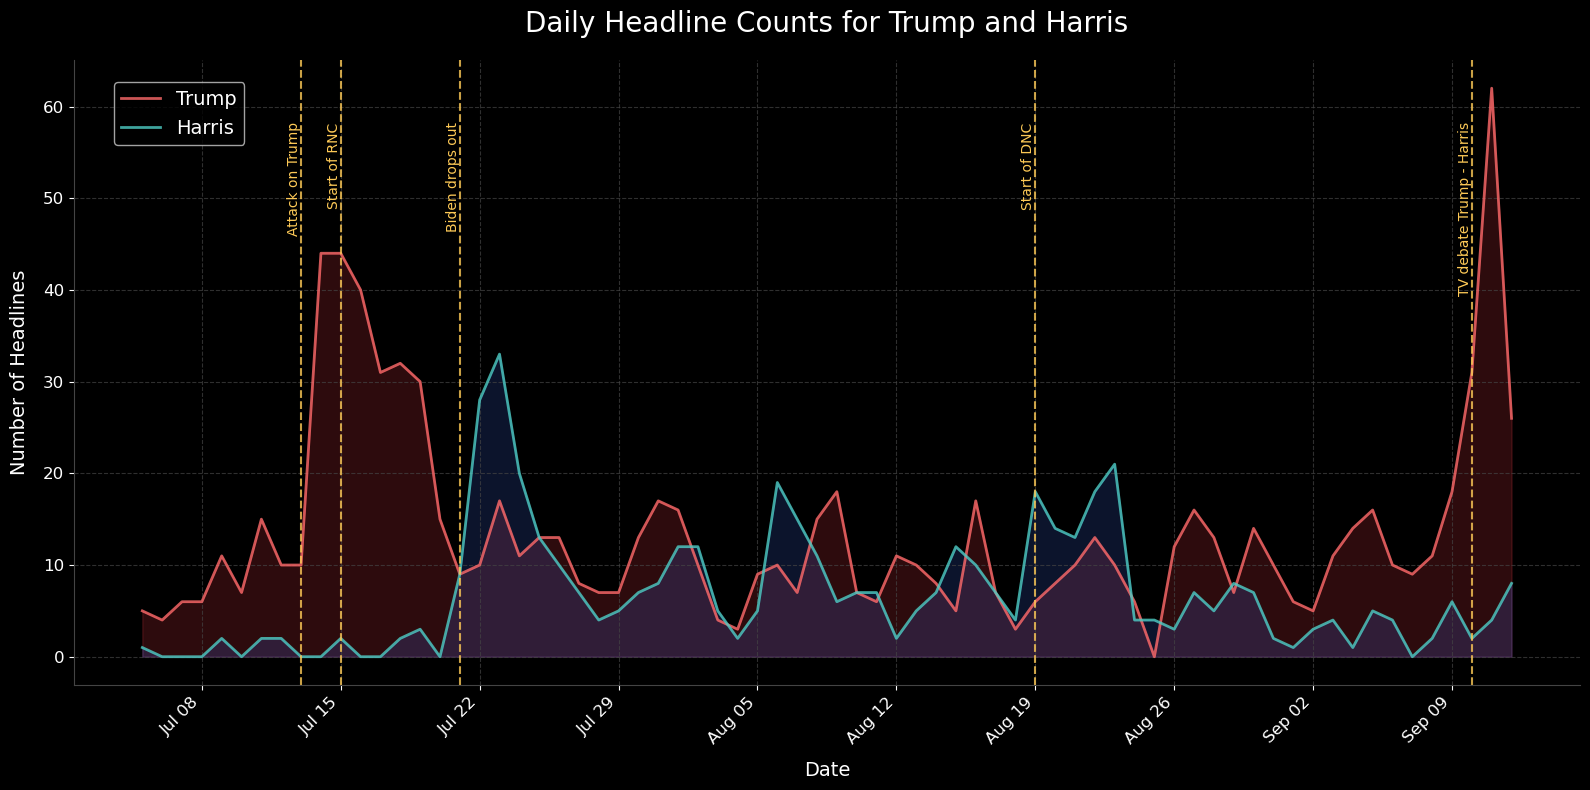


Example Trump headlines and sentiments:
Headline: harris says trump will repeal obamacare. trump now claims he’ll make it ‘better.’
Sentiment: neutral

Headline: the problem is not a.i. it’s the disbelief created by trump.
Sentiment: negative

Headline: what donald trump calling kamala harris a ‘communist’ shows
Sentiment: neutral


Example Harris headlines and sentiments:
Headline: ‘veep’ comparisons dominate social media as biden endorses kamala harris
Sentiment: positive

Headline: what is the ‘khive’? kamala harris’s fandom goes back to her time in congress
Sentiment: neutral

Headline: attacking kamala harris for not having kids will backfire
Sentiment: negative



In [95]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import random

def plot_time_series(daily_counts, daily_sentiments):
    dates = sorted(daily_counts.keys())
    trump_counts = [daily_counts[date]['trump'] for date in dates]
    harris_counts = [daily_counts[date]['harris'] for date in dates]

    # Convert string dates to datetime objects
    dates = [datetime.strptime(date, '%Y/%m/%d') for date in dates]

    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(16, 8))

    ax.plot(dates, trump_counts, color='#ff6b6b', alpha=0.8, linewidth=2)
    ax.plot(dates, harris_counts, color='#4ecdc4', alpha=0.8, linewidth=2)

    ax.set_title('Daily Headline Counts for Trump and Harris', fontsize=20, pad=20)
    ax.set_xlabel('Date', fontsize=14, labelpad=10)
    ax.set_ylabel('Number of Headlines', fontsize=14, labelpad=10)
    ax.legend(['Trump', 'Harris'], fontsize=14, loc='upper left', bbox_to_anchor=(0.02, 0.98))

    ax.grid(True, color='#444444', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#444444')
    ax.spines['bottom'].set_color('#444444')
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Format x-axis ticks
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Add event markers
    events = [
        ('2024/07/13', "Attack on Trump"),
        ('2024/07/15', "Start of RNC"),
        ('2024/07/21', "Biden drops out"),
        ('2024/08/19', "Start of DNC"),
        ('2024/09/10', "TV debate Trump - Harris")
    ]

    # Calculate the height for event markers (90% of the plot height)
    y_min, y_max = ax.get_ylim()
    marker_height = y_min + (y_max - y_min) * 0.9

    for date_str, label in events:
        date = datetime.strptime(date_str, '%Y/%m/%d')
        ax.axvline(date, ymin=0, ymax=1, color='#feca57', linestyle='--', alpha=0.8)
        ax.text(date, marker_height, label, rotation=90, va='top', ha='right', fontsize=10, color='#feca57')

    # Add some visual enhancements
    ax.fill_between(dates, trump_counts, alpha=0.2, color='#E63946')
    ax.fill_between(dates, harris_counts, alpha=0.2, color='#4169E1')

    plt.tight_layout()
    plt.show()

# Process the CSV file and create the visualization
trump_headlines, harris_headlines, total_headlines, daily_counts, daily_sentiments = process_headlines('categorized_nyt_articles.csv')
plot_time_series(daily_counts, daily_sentiments)

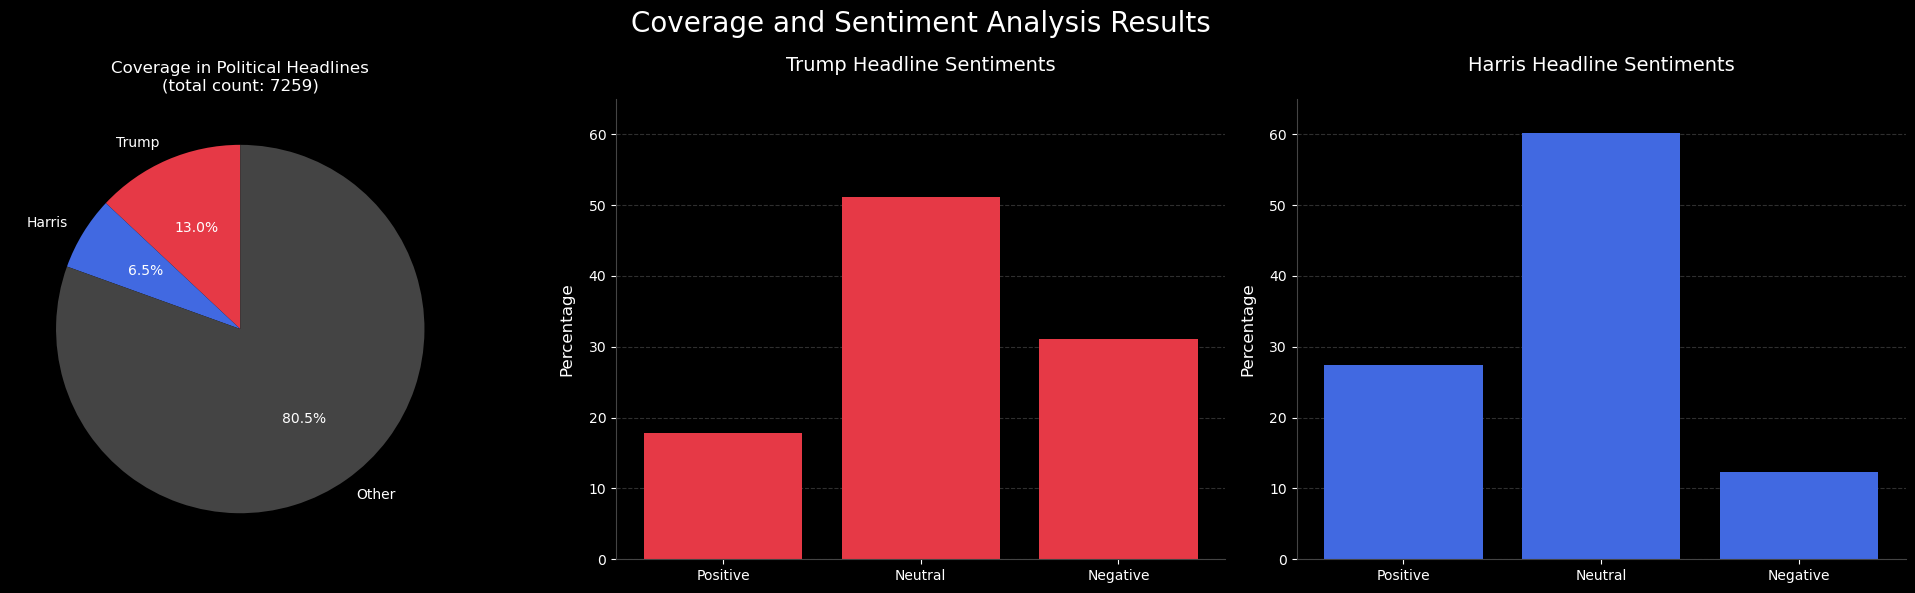

In [103]:
import matplotlib.pyplot as plt

def create_charts(total_headlines, trump_headlines, harris_headlines, trump_sentiments, harris_sentiments):
    # Set the style to match the provided example
    plt.style.use('dark_background')

    # Create a figure with two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Coverage and Sentiment Analysis Results', fontsize=20, color='white')

    # Pie chart for coverage
    coverage_labels = ['Trump', 'Harris', 'Other']
    coverage_sizes = [len(trump_headlines), len(harris_headlines), 
                      total_headlines - len(trump_headlines) - len(harris_headlines)]
    colors = ['#E63946', '#4169E1', '#444444']

    ax1.pie(coverage_sizes, labels=coverage_labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title(f'Coverage in Political Headlines\n(total count: {total_headlines})', color='white')

    # Function to style bar charts
    def style_bar_chart(ax, values, title, color):
        sentiments = ['Positive', 'Neutral', 'Negative']
        ax.bar(sentiments, values, color=color)
        ax.set_title(title, color='white', fontsize=14, pad=20)
        ax.set_ylabel('Percentage', color='white', fontsize=12, labelpad=10)
        ax.tick_params(axis='both', colors='white', labelsize=10)
        ax.set_ylim(0, 65)
        ax.yaxis.grid(True, color='#444444', linestyle='--', alpha=0.7)
        ax.set_axisbelow(True) # Show grid behind the bars

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#444444')
        ax.spines['bottom'].set_color('#444444')

    # Bar chart for Trump sentiments
    trump_values = [trump_sentiments['positive'], trump_sentiments['neutral'], trump_sentiments['negative']]
    style_bar_chart(ax2, trump_values, 'Trump Headline Sentiments', '#E63946')
    
    # Bar chart for Harris sentiments
    harris_values = [harris_sentiments['positive'], harris_sentiments['neutral'], harris_sentiments['negative']]
    style_bar_chart(ax3, harris_values, 'Harris Headline Sentiments', '#4169E1')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Analyze sentiments
trump_sentiments = analyze_headlines(trump_headlines)
harris_sentiments = analyze_headlines(harris_headlines)

# Create the charts
create_charts(total_headlines, trump_headlines, harris_headlines, trump_sentiments, harris_sentiments)

trump_sentiments = analyze_headlines(trump_headlines)
harris_sentiments = analyze_headlines(harris_headlines)

## Part 4: Political Bias Analysis

100%|██████████| 7259/7259 [08:06<00:00, 14.93it/s]


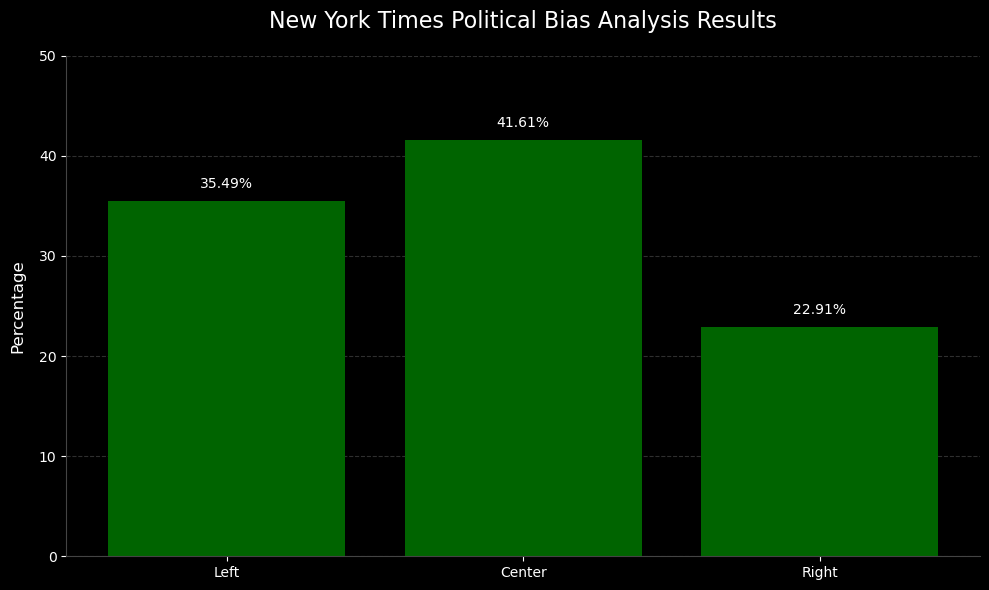


Example Title Predictions:

Title: Today’s Paper
Left: 0.44, Right: 0.19, Center: 0.36

Title: 2024
Left: 0.16, Right: 0.59, Center: 0.26

Title: Muere Alberto Fujimori, expresidente de Perú condenado por abusos a los DD. HH.
Left: 0.33, Right: 0.14, Center: 0.53

Title: After a Bruising Debate, Trump Is Warmly Embraced in Lower Manhattan
Left: 0.47, Right: 0.24, Center: 0.29

Title: Certification of Election Will Get Extra Security to Try to Prevent Another Capitol Attack
Left: 0.26, Right: 0.28, Center: 0.46


In [68]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("categorized_nyt_articles.csv")

# Filter for Politics category
politics_df = df[df["predicted_category"] == "Politics"]

# Load the model and tokenizer
model_name = "bucketresearch/politicalBiasBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to predict political bias
def predict_bias(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probabilities[0].tolist()

# Process articles and calculate average bias
total_left = 0
total_right = 0
total_center = 0
count = 0

for _, row in tqdm(politics_df.iterrows(), total=len(politics_df)):
    title = row['title']  # Use the title column for analysis
    bias_probs = predict_bias(title)
    total_left += bias_probs[0]
    total_right += bias_probs[1]
    total_center += bias_probs[2]
    count += 1

# Calculate percentages
if count > 0:
    left_percent = (total_left / count) * 100
    right_percent = (total_right / count) * 100
    center_percent = (total_center / count) * 100

# Store the bias values
bias_results = {
    'Left': left_percent,
    'Center': center_percent,
    'Right': right_percent
}

def create_bias_chart(bias_results):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 6))
    categories = list(bias_results.keys())
    values = list(bias_results.values())
    colors = ['darkgreen', 'darkgreen', 'darkgreen']
    ax.bar(categories, values, color=colors)
    ax.set_title('New York Times Political Bias Analysis Results', fontsize=16, pad=20)
    ax.set_ylabel('Percentage', fontsize=12, labelpad=10)
    ax.set_ylim(0, 50)  # Set y-axis from 0 to 50% for better visibility of differences
    
    # Add value labels on top of each bar
    for i, v in enumerate(values):
        ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontsize=10, color='white')
    
    ax.yaxis.grid(True, color='#444444', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)  # Draw grid lines behind the bars
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#444444')
    ax.spines['bottom'].set_color('#444444')
    ax.tick_params(axis='both', colors='white', labelsize=10)
    
    plt.tight_layout()
    plt.show()

# Create the chart
create_bias_chart(bias_results)

# Print some example titles and their predicted biases
print("\nExample Title Predictions:")
for _, row in politics_df.head().iterrows():
    title = row['title']
    bias_probs = predict_bias(title)
    print(f"\nTitle: {title}")
    print(f"Left: {bias_probs[0]:.2f}, Right: {bias_probs[1]:.2f}, Center: {bias_probs[2]:.2f}")